### Distribution map of COVID-19 cases in Pernambuco

The final map is intended to be submitted to wikidata item [Q90314366](https://www.wikidata.org/wiki/Q90314366).

Data acquired from [here](http://dados.seplag.pe.gov.br/apps/corona.html#dados-pe)

The [original notebook](https://github.com/lubianat/covid_19_sandbox/blob/master/sao_paulo_covid/Map%20of%20Covid-19%20Cases%20in%20S%C3%A3o%20Paulo.ipynb) was made by Tiago Lubiana for São Paulo state, this is merely an adaption.

In [1]:
import pandas as pd
from datetime import date,datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
mapa_dos_municipios_de_pe = gpd.read_file("../../estados_shapes/unzipped/26MUE250GC_SIR.shp")

In [3]:
mapa_dos_municipios_de_pe.columns

Index(['NM_MUNICIP', 'CD_GEOCMU', 'geometry'], dtype='object')

In [4]:
mapa_dos_municipios_de_pe.columns = ['mun_notificacao', 'cd_municipio', 'geometry']
mapa_dos_municipios_de_pe.head()

,mun_notificacao,cd_municipio,geometry
0,ABREU E LIMA,2600054,"POLYGON ((-35.05411 -7.88004, -35.02347 -7.888..."
1,AFOGADOS DA INGAZEIRA,2600104,"POLYGON ((-37.55881 -7.63922, -37.55884 -7.640..."
2,AFRÂNIO,2600203,"POLYGON ((-40.86179 -8.37065, -40.85241 -8.445..."
3,AGRESTINA,2600302,"POLYGON ((-35.92102 -8.36590, -35.90399 -8.374..."
4,ÁGUA PRETA,2600401,"POLYGON ((-35.47084 -8.54594, -35.46916 -8.545..."


Data for Pernambuco was acquired [here](http://dados.seplag.pe.gov.br/apps/corona.html#dados-pe)

In [5]:
pe_bruto = pd.read_csv("./COVID-19 no Mundo, no Brasil e em Pernambuco.csv")
print(pe_bruto.shape)
pe_bruto.head()

(6303, 15)


,X,id,dt_notificacao,Idade,Sexo,mun_notificacao,dt_primeiros_sintomas,sintomas,comorbidades,hospitalizacao,classe,Resultado,evolucao,dt_obito,cd_municipio
0,1,3489,09/04/2020,NaN,FEMININO,RECIFE,NaN,Febre - Tosse - Dor de Garganta - Desconforto ...,NaN,NÃO,EM INVESTIGAÇÃO,AGUARDANDO RESULTADO,NaN,NaN,261160
1,2,3586,09/04/2020,34.0,MASCULINO,RECIFE,09/04/2020,NaN,NaN,NÃO,DESCARTADO,NEGATIVO INFLUENZA/NEGATIVO SARS-COV-2,NaN,NaN,261160
2,3,3581,08/04/2020,0.0,MASCULINO,RECIFE,08/04/2020,Desconforto respiratório,NaN,SIM,DESCARTADO,NEGATIVO INFLUENZA/NEGATIVO SARS-COV-2,INTERNADO UTI,NaN,261160
3,4,3549,09/04/2020,60.0,FEMININO,RECIFE,06/04/2020,Febre - Tosse,NaN,NaN,CONFIRMADO,SARS-COV-2,ISOLAMENTO DOMICILIAR,NaN,261160
4,5,3952,09/04/2020,42.0,FEMININO,RECIFE,NaN,Febre - Tosse - Dor de Garganta - Desconforto ...,NaN,NaN,EM INVESTIGAÇÃO,AGUARDANDO RESULTADO,NaN,NaN,261160


In [6]:
pe_bruto = pe_bruto.query("classe == 'CONFIRMADO'")
print(pe_bruto.shape)
pe_bruto.head()

(1683, 15)


,X,id,dt_notificacao,Idade,Sexo,mun_notificacao,dt_primeiros_sintomas,sintomas,comorbidades,hospitalizacao,classe,Resultado,evolucao,dt_obito,cd_municipio
3,4,3549,09/04/2020,60.0,FEMININO,RECIFE,06/04/2020,Febre - Tosse,NaN,NaN,CONFIRMADO,SARS-COV-2,ISOLAMENTO DOMICILIAR,NaN,261160
10,11,3296,09/04/2020,29.0,FEMININO,RECIFE,31/03/2020,Febre - Dispneia - Desconforto respiratório,NaN,SIM,CONFIRMADO,AGUARDANDO INFLUENZA/SARS-COV-2,ISOLAMENTO DOMICILIAR,NaN,261160
29,30,4002,10/04/2020,35.0,MASCULINO,RECIFE,07/04/2020,Febre - Tosse - Dor de Garganta,NaN,NÃO,CONFIRMADO,NEGATIVO INFLUENZA/SARS-COV-2,ISOLAMENTO DOMICILIAR,NaN,261160
43,44,3289,09/04/2020,34.0,FEMININO,RECIFE,07/04/2020,Febre - Tosse - Dor de Garganta,NaN,NÃO,CONFIRMADO,NEGATIVO INFLUENZA/SARS-COV-2,ISOLAMENTO DOMICILIAR,NaN,261160
49,50,3562,09/04/2020,84.0,MASCULINO,RECIFE,31/03/2020,Tosse - Dispneia - Desconforto respiratório - ...,NaN,SIM,CONFIRMADO,NEGATIVO INFLUENZA/SARS-COV-2,ISOLAMENTO DOMICILIAR,NaN,261160


In [7]:
pe_info = pe_bruto.copy(deep=True)
pe_info = pe_bruto.loc[:,['mun_notificacao', 'classe', 'evolucao']]

pe_conf = pd.DataFrame(pe_info.groupby(['mun_notificacao'])['classe']
                       .count()).reset_index()

pe_obt = pd.DataFrame(pe_info.query("evolucao == 'ÓBITO'")
                      .groupby(['mun_notificacao'])['evolucao']
                      .count()).reset_index()

In [8]:
map_obt = pd.merge(mapa_dos_municipios_de_pe, pe_obt, on='mun_notificacao', how='left')
map_conf = pd.merge(mapa_dos_municipios_de_pe, pe_conf, on='mun_notificacao', how='left')
mapa_data = pd.merge(map_conf, map_obt['evolucao'], left_index=True, right_index=True, how='outer')
mapa_data

,mun_notificacao,cd_municipio,geometry,classe,evolucao
0,ABREU E LIMA,2600054,"POLYGON ((-35.05411 -7.88004, -35.02347 -7.888...",17.0,NaN
1,AFOGADOS DA INGAZEIRA,2600104,"POLYGON ((-37.55881 -7.63922, -37.55884 -7.640...",NaN,NaN
2,AFRÂNIO,2600203,"POLYGON ((-40.86179 -8.37065, -40.85241 -8.445...",NaN,NaN
3,AGRESTINA,2600302,"POLYGON ((-35.92102 -8.36590, -35.90399 -8.374...",NaN,NaN
4,ÁGUA PRETA,2600401,"POLYGON ((-35.47084 -8.54594, -35.46916 -8.545...",NaN,NaN
...,...,...,...,...,...
180,VERTENTE DO LÉRIO,2616183,"POLYGON ((-35.78991 -7.74044, -35.77142 -7.765...",NaN,NaN
181,VERTENTES,2616209,"POLYGON ((-35.94335 -7.78999, -35.92838 -7.819...",NaN,NaN
182,VICÊNCIA,2616308,"POLYGON ((-35.25953 -7.67565, -35.29392 -7.708...",NaN,NaN
183,VITÓRIA DE SANTO ANTÃO,2616407,"POLYGON ((-35.19577 -8.07954, -35.21132 -8.112...",11.0,2.0


In [9]:
mapa_data["evolucao"] = mapa_data["evolucao"].fillna(0)
mapa_data["classe"] = mapa_data["classe"].fillna(0)

mapa_data["obitos_categorizados"] = pd.cut(mapa_data["evolucao"],
                                                    bins = [-1,1,3,6,10,50],
                                                    labels = ["0", "1-3", "4-6", "7-10", "11-50"])


mapa_data["casos_categorizados"] = pd.cut(mapa_data["classe"],
                                                   bins = [-1,1, 10,50,500,1000, 100000000],
                                                   labels = ["0", "1-10", "11-50", "51-500",">500", ">1000"])


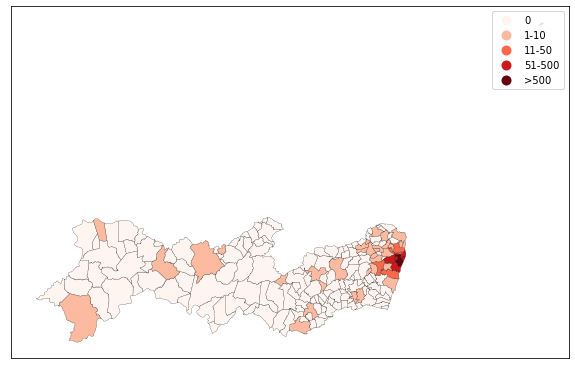

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
ax = mapa_data.plot(column='casos_categorizados',
                         categorical=True, 
                         legend=True, 
                         figsize=(10,10),
                         markersize=45,
                         cmap = "Reds",
                         edgecolor='k',
                         linewidth=0.2,
                         ax=ax);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig("figs/casos_pe_" + "16_april" + ".png", dpi = 300)